# COVID binary classification
In this *notebook* we design a ConvNet to binary classification COVID-19 images.The model distinguishes between covid patient radiographs and others (pneumonia patients and healthy people). The deep model is an inception net, with five inception blocks. Each block has four convolutional layers with filters of 1x1,1x1, 3x3 and 5x5, also the block has MaxPooling layers before the convolutional layers. 

The dataset contains very little images of COVID patients, specifically 87 in the train set and only 10 to test, for this reason, we use the SMOTE Algorithm to generate new samples of COVID images.

In [1]:
__author__ = '@iRodGit'
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Add
from keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, concatenate # Concatenate
from keras.models import Sequential, Model
from keras.utils import to_categorical
from codvidutils.imageproc import map_categorical

Using TensorFlow backend.


## Load and pre-processing data

In [2]:
train_class = pd.read_csv('data/train_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [3]:
train_pics = []
for img in train_class['image_path'].values:
    train_pics.append(np.array(Image.open('data/train/' + img))[:, :,0])
test_pics = []
for img in test_class['image_path'].values:
    test_pics.append(np.array(Image.open('data/test/' + img))[:, :, 0])

In [4]:
values_dict = {'COVID-19': 1,'pneumonia': 2,  'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

In [5]:
X_train = np.array(train_pics)
del train_pics
X_test = np.array(test_pics)
del test_pics
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, diseaseID_train.shape, X_test.shape, diseaseID_test.shape))

Train shape X: (16574, 200, 200),  Y: (16574,) 
 Test shape X: (1953, 200, 200), Y: (1953,)


## Imbalanced methods
We reduce the NO-COVID images and create new COVID images with the SMOTE Algorithm

In [6]:
from collections import Counter
counter = Counter (diseaseID_train)
print(counter)

Counter({2: 8521, 0: 7966, 1: 87})


In [7]:
dicto = {2: 5000, 0: 5000, 1:87}
dicto

{0: 5000, 1: 87, 2: 5000}

In [8]:
X_train = X_train.reshape(X_train.shape[0],-1)
print(X_train.shape)

(16574, 40000)


In [9]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy =dicto)
Xnew, diseaseID_train = under.fit_resample(X_train, diseaseID_train)
# summarize class distribution
print(diseaseID_train.shape)
print(Xnew.shape)

(10087,)
(10087, 40000)


In [10]:
Y_train = np.copy(diseaseID_train)
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.5)
X_train, Y_train = oversample.fit_resample(Xnew, Y_train)
# summarize class distribution
counter = Counter(Y_train)
print(counter)

Counter({0: 10000, 1: 5000})


In [12]:
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_test.shape)

(1953, 40000)


In [13]:
oversample = SMOTE(sampling_strategy=0.5)
X_test,Y_test = oversample.fit_sample(X_test, Y_test)
# summarize class distribution
counter = Counter(Y_test)
print(counter)

Counter({0: 1943, 1: 971})


In [14]:
X_train = X_train.reshape(X_train.shape[0],200,200,1)
X_test = X_test.reshape(X_test.shape[0],200,200,1)
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)
X_train, X_test = X_train/255, X_test/255

## Deep model

In [15]:
def inception_block (previous_layer,filters =[64,128,32,32]):
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1,1), activation='relu')(previous_layer)
    conv1x1_2 = Conv2D(filters=filters[1], kernel_size=(1,1), activation='relu')(previous_layer)
    conv1x1_3 = Conv2D(filters=filters[2], kernel_size=(1,1), activation='relu')(previous_layer)
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), activation='relu',padding="same")(conv1x1_2)
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5,5), activation='relu',padding="same")(conv1x1_3)
    max_pool= MaxPooling2D(pool_size=(3,3),padding="same",strides=1)(previous_layer)
    conv_max = Conv2D(filters=filters[3], kernel_size=(1,1), activation='relu',padding="same")(max_pool)
    inception = concatenate([conv1x1, conv3x3,conv5x5,conv_max])
    return inception

In [16]:
"""
Incep_5 archiquecture using Functional api
"""
input_layer = Input(shape= (200,200,1,))
inception_1 = inception_block(input_layer)
pool_1 = MaxPooling2D()(inception_1)
inception_2 = inception_block(pool_1)
pool_2 = MaxPooling2D()(inception_2)
inception_3 = inception_block(pool_2)
pool_3= MaxPooling2D()(inception_3)
inception_4 = inception_block(pool_3)
pool_4= MaxPooling2D()(inception_4)
inception_5 = inception_block(pool_4)
pool_5= MaxPooling2D(pool_size= (4,4))(inception_5)
conv_FC = Conv2D(filters =128,kernel_size =(3,3),activation="relu")(pool_5)
first_dense = Conv2D(filters =32,kernel_size =(1,1),activation="relu")(conv_FC)
#sec_dense = Conv2D(filters =16,kernel_size =(1,1),activation="relu")(first_dense)
flat = Flatten()(first_dense)
out_layer= Dense(units =1, activation= "sigmoid")(flat)
deep = Model(inputs=input_layer, outputs=out_layer)


deep.summary()
from keras.utils import plot_model
plot_model(deep, to_file='inception.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 200, 200, 128 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 200, 200, 32) 64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 200, 200, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [17]:
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Train shape X: (15000, 200, 200, 1),  Y: (15000, 1) 
 Test shape X: (2914, 200, 200, 1), Y: (2914, 1)


In [18]:
from keras.callbacks import ModelCheckpoint

filepath="Inception_bestmodel_trained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',"mse"])
history = deep.fit(X_train, Y_train, epochs=5, batch_size=32, callbacks= [checkpoint],verbose=2, validation_data=(X_test, Y_test))


Train on 15000 samples, validate on 2914 samples
Epoch 1/5
 - 163s - loss: 0.1358 - acc: 0.9468 - mean_squared_error: 0.0393 - val_loss: 0.1210 - val_acc: 0.9520 - val_mean_squared_error: 0.0357

Epoch 00001: val_acc improved from -inf to 0.95196, saving model to Inception_bestmodel_trained.hdf5
Epoch 2/5
 - 154s - loss: 0.0496 - acc: 0.9835 - mean_squared_error: 0.0127 - val_loss: 0.1611 - val_acc: 0.9465 - val_mean_squared_error: 0.0420

Epoch 00002: val_acc did not improve
Epoch 3/5
 - 154s - loss: 0.0344 - acc: 0.9895 - mean_squared_error: 0.0086 - val_loss: 0.1706 - val_acc: 0.9550 - val_mean_squared_error: 0.0374

Epoch 00003: val_acc improved from 0.95196 to 0.95504, saving model to Inception_bestmodel_trained.hdf5
Epoch 4/5
 - 154s - loss: 0.0196 - acc: 0.9933 - mean_squared_error: 0.0051 - val_loss: 0.0876 - val_acc: 0.9763 - val_mean_squared_error: 0.0197

Epoch 00004: val_acc improved from 0.95504 to 0.97632, saving model to Inception_bestmodel_trained.hdf5
Epoch 5/5
 - 154s

In [19]:
pred = deep.predict(X_test)
pred.shape

(2914, 1)

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresold = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.9964376067035114


In [ ]:
from keras.models import load_model
model = load_model("CNN_best_modeltrained.hdf5")
pred = model.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(Y_test, pred.round())
print(cm)
print("Original data")
cm= confusion_matrix(Y_test[:1953], pred[:1953].round())
print(cm)

[[1927   16]
 [ 109  862]]
Original data
[[1927   16]
 [   9    1]]


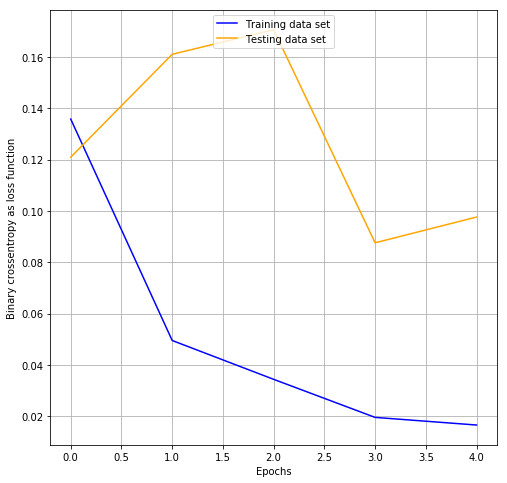

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6

plt.grid(True)
plt.plot(history.history["loss"], color="blue", label="Training data set")
plt.plot(history.history["val_loss"], color="orange", label="Testing data set")
plt.ylabel('Binary crossentropy as loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper center')
plt.show()

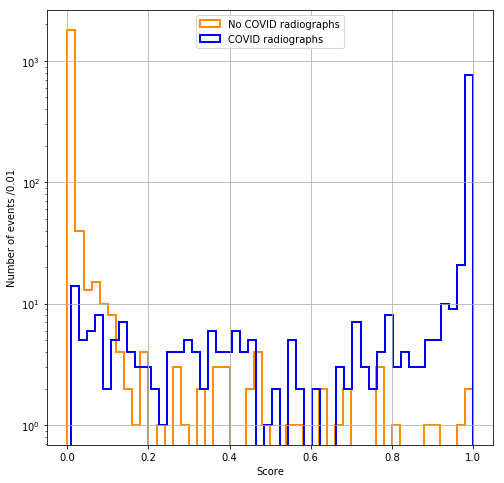

In [23]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)

lw=2
plt.hist(pred[(Y_test==0)],50,histtype='step',lw=lw,color='darkorange', label= "No COVID radiographs")
plt.hist(pred[(Y_test==1)],50,histtype='step',lw=lw,color='blue', label= "COVID radiographs")
plt.ylabel('Number of events /0.01')
plt.xlabel('Score')
plt.yscale("log")
plt.legend( loc='upper center')
plt.show()

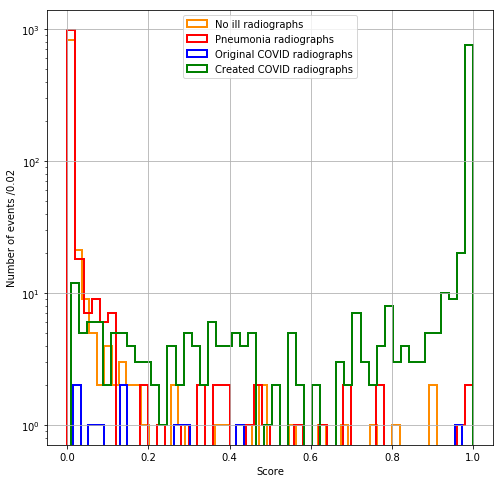

In [24]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)

lw=2
plt.hist(pred[:1953][(diseaseID_test==0)],50,histtype='step',lw=lw,color='darkorange', label= "No ill radiographs")
plt.hist(pred[:1953][(diseaseID_test==2)],50,histtype='step',lw=lw,color='red', label= "Pneumonia radiographs")
plt.hist(pred[:1953][(diseaseID_test==1)],50,histtype='step',lw=lw,color='blue', label= "Original COVID radiographs")
plt.hist(pred[1953:],50,histtype='step',lw=lw,color='green', label= "Created COVID radiographs")

plt.ylabel('Number of events /0.02')
plt.xlabel('Score')
plt.yscale("log")
plt.legend( loc='upper center')
plt.show()

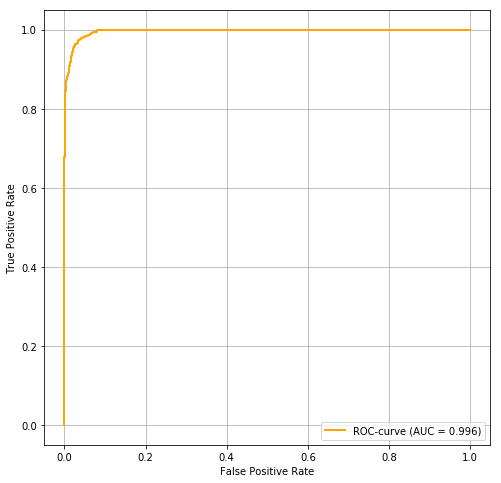

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC-curve (AUC = %0.3f)' % (roc_auc))


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower right")
plt.show()